In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [2]:
import math


In [6]:
math.factorial(3)

6

In [6]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [7]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, link, init_type, optim_type, scaling_factor=1, k=0, track=None,
                    win=1000,
                    L=49,
                    C=1,
                    emiter=20,
                    K=2
):
    fs = 1000
    delta = 1/fs
    seed = 8
    print()


    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    data_path = f'saved/synthetic_data/simple_latent_deltarelu_fixed_gamma_{K}_{L}_{sample_length}'
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    zs = latent['zs']
    xs = latent['xs']




    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])

    lams = cif_alpha_relu(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[k,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'

    model_load = pickle_open(model_path)
    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:49,k,k].real
    S_oracle = Gamma_zest[:49,k,k].real
    S_init = Gamma_init[:49,k,k].real

    S_true = S_true*scaling_factor
    S_oracle = S_oracle*scaling_factor
    S_init = S_init*scaling_factor

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:49]
    coh_true = thr_coherence(Gamma[:49,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:49,:,:])
    coh_init = thr_coherence(Gamma_init[:49,:,:])



    if track is not None:
        S_model = []
        coh_model = []

        for e in range(track[0], track[1]):
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:49,k,k].real
            S_model_itr = S_model_itr*scaling_factor
            coh_model_itr = thr_coherence(Gamma_est_itr[:49,:,:])

            S_model.append(S_model_itr)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:49,k,k].real
        S_model = S_model*scaling_factor
        coh_model = thr_coherence(Gamma_est[:49,:,:])

    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)

    return dict(coh=coh_dict, S=S_dict, spikes=spikes, lams=lams)



In [14]:
link = 'relu'
init_type = 'oracle'
optim_type = 'Newton'
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2
scaling_factor = ((np.pi)/fs)*(np.pi/J)*(sample_length/J)

In [122]:
from cohlib.conv import conv_v_to_z
from cohlib.alg.em_sgc import get_trial_obj, compute_Gamma_real_logdet
K = 2
L = 50
em_iters = 20
seed = 7
alpha = 400
alpha = float(alpha)



C = 1
init_type = 'flat'
model_path = f'saved/fitted_models/simple_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'
model_load = pickle_open(model_path)
Gamma_inv_init_flat = model_load['inv_init']

init_type = 'oracle'
model_path = f'saved/fitted_models/simple_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'
model_load = pickle_open(model_path)
Gamma_inv_init_oracle = model_load['inv_init']

In [ ]:

model_path = f'saved/fitted_models/simple_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'
model_load = pickle_open(model_path)

In [71]:
Gamma_true = data_load['latent']['Gamma']
zs = data_load['latent']['zs']
vs = data_load['latent']['vs']
xs = data_load['latent']['xs']



spikes = model_load['spikes']
spikes_grouped = [spikes[:,:,k,:] for k in range(K)]
data = spikes_grouped
Wv = model_load['Wv']
W = Wv

### 

In [ ]:
max_approx_iters = 50
num_J_vars = Wv.shape[1]
l = 0
params = [dict(alpha=alpha) for k in range(K)]
taper = None

In [123]:
estep_params = dict(
    init_flat=Gamma_inv_init_flat,
    init_oracle=Gamma_inv_init_oracle,
    data=data,
    Wv=Wv,
    max_iters=500,
    model_params=params,
    K=K,
    L=L
)

In [125]:
def run_E_step(init_type, optim_type, estep_params):
    Gamma_inv_init_flat = estep_params['init_flat']
    Gamma_inv_init_oracle = estep_params['init_oracle']
    data = estep_params['data']
    K = estep_params['K']
    L = estep_params['L']
    W = estep_params['Wv']
    num_J_vars = W.shape[1]
    max_iters = estep_params['max_iters']
    params = estep_params['model_params']
    obs_model = 'poisson-relu-delta'

    if init_type == 'flat':
        Gamma_inv_init = Gamma_inv_init_flat
    elif init_type == 'oracle':
        Gamma_inv_init = Gamma_inv_init_oracle
    else:
        raise ValueError

    Gamma_prev_inv = Gamma_inv_init
    Gamma_init = deconstruct_Gamma_full_real(Gamma_inv_init, K, num_J_vars, invert=True)
    Gamma_prev_real_logdet = compute_Gamma_real_logdet(Gamma_init)

    mus = np.zeros((L, K * num_J_vars))
    Ups_invs = np.zeros((L, K * num_J_vars, K * num_J_vars))
    for l in range(L):
        trial = get_trial_obj(
            data, l, W, Gamma_prev_inv, params, taper=taper, obs_model=obs_model, optim_type=optim_type,
        Gamma_prev_logdet=Gamma_prev_real_logdet)
        mu, fisher_info = trial.laplace_approx(max_approx_iters)
        mus[l,:] = mu

    return mus

In [126]:
# def plot_optim_result(mus, zs, init_type, optim_type, j, k, free_scale):
#     mus_sorted = np.zeros((L, J_max, 2*K))
#     for l in range(L):
#         mus_sorted[l,:,:] = np.stack(get_freq_vecs_real(mus[l,:], K, num_J_vars))
#     mus_sorted = mus_sorted.swapaxes(1,2)
#     mus_z = conv_v_to_z(mus_sorted[:,:,], axis=1, dc=False)

#     color = plt.cm.rainbow(np.linspace(0, 1, L))

#     fig, ax = plt.subplots(1,2,figsize=(6,3))
#     ax[0].scatter(mus_z[:,k,j].real, mus_z[:,k,j].imag, c=color)
#     ax[0].set_title(f'Estimated -' + r' $\hat{z}_j^{\ell}$')
#     ax[1].scatter(zs[:,k,j].real, zs[:,k,j].imag, c=color)
#     ax[1].set_title(f'True -' + r' $z_j^{\ell}$' )

#     fig.suptitle(f'Oracle E-Step {optim_type} - {j+1} Hz; k = {k}')
#     # ax[1].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
#     # ax[1].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
#     # ax[1].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

#     lim = 1.2*np.max(np.concatenate([mus_z[:,k,j].real, mus_z[:,k,j].imag, zs[:,k,j].real, zs[:,k,j].imag]))
#     for i in range(2):
#         ax[i].set_xlabel('Re', fontweight='bold', fontsize=14)
#         ax[i].set_ylabel('Im', fontweight='bold', fontsize=14)
#         if free_scale is False:
#             ax[i].set_xlim([-lim,lim])
#             ax[i].set_ylim([-lim,lim])
#     plt.tight_layout()
#     plt.show()

In [131]:
def plot_optim_result(mus, zs, init_type, optim_type, j, k, free_scale):
    mus_sorted = np.zeros((L, J_max, 2*K))
    for l in range(L):
        mus_sorted[l,:,:] = np.stack(get_freq_vecs_real(mus[l,:], K, num_J_vars))
    mus_sorted = mus_sorted.swapaxes(1,2)
    mus_z = conv_v_to_z(mus_sorted[:,:,], axis=1, dc=False)

    color = plt.cm.rainbow(np.linspace(0, 1, L))

    fig, ax = plt.subplots(1,4,figsize=(12,3))
    ax[0].scatter(mus_z[:,k,j].real, mus_z[:,k,j].imag, c=color)
    ax[0].set_title(f'Estimated -' + r' $\hat{z}_j^{\ell}$')
    ax[1].scatter(zs[:,k,j].real, zs[:,k,j].imag, c=color)
    ax[1].set_title(f'True -' + r' $z_j^{\ell}$' )
    ax[2].scatter(mus_z[:,k,j].real, zs[:,k,j].real, c=color)
    ax[2].set_xlabel('Estimated', fontweight='bold', fontsize=14)
    ax[2].set_ylabel('True', fontweight='bold', fontsize=14)
    ax[2].set_title(f'Compare Real -' + r' $z_j^{\ell}$' )
    ax[3].scatter(mus_z[:,k,j].imag, zs[:,k,j].imag, c=color)
    ax[3].set_xlabel('Estimated', fontweight='bold', fontsize=14)
    ax[3].set_ylabel('True', fontweight='bold', fontsize=14)
    ax[3].set_title(f'Compare Imag -' + r' $z_j^{\ell}$' )

    fig.suptitle(f'{init_type} E-Step {optim_type} - {j+1} Hz; k = {k}')
    # ax[1].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
    # ax[1].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
    # ax[1].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

    lim = 1.2*np.max(np.concatenate([mus_z[:,k,j].real, mus_z[:,k,j].imag, zs[:,k,j].real, zs[:,k,j].imag]))
    for i in range(2):
        ax[i].set_xlabel('Re', fontweight='bold', fontsize=14)
        ax[i].set_ylabel('Im', fontweight='bold', fontsize=14)
        if free_scale is False:
            ax[i].set_xlim([-lim,lim])
            ax[i].set_ylim([-lim,lim])
    plt.tight_layout()
    plt.show()

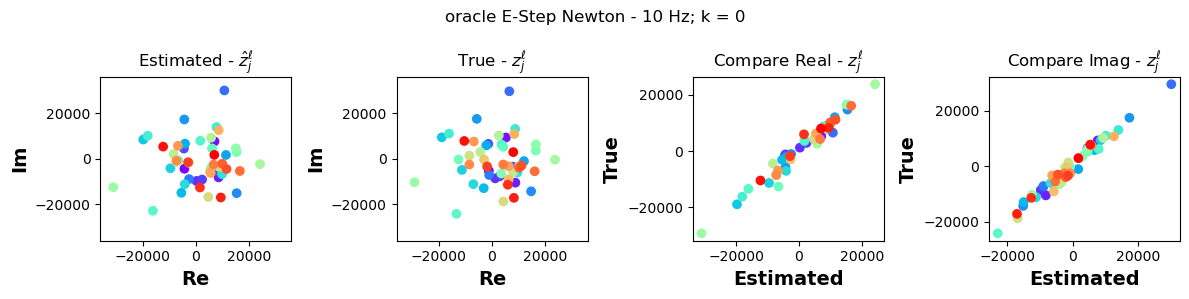

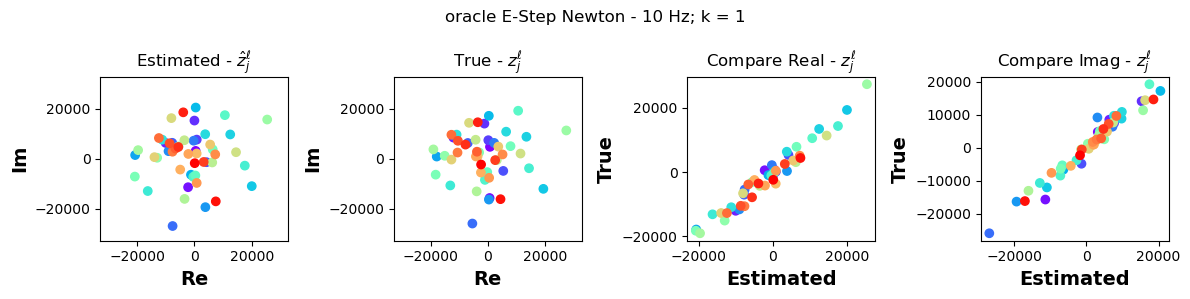

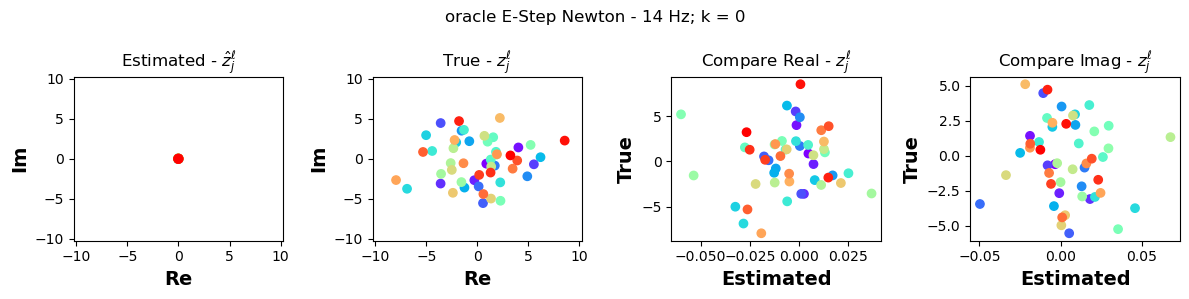

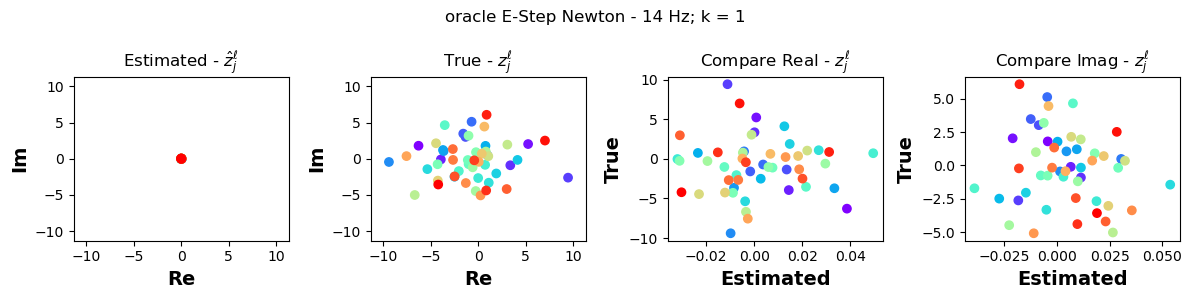

In [132]:
init_type = 'oracle'
optim_type = 'Newton'
mus = run_E_step(init_type, optim_type, estep_params)
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,False)

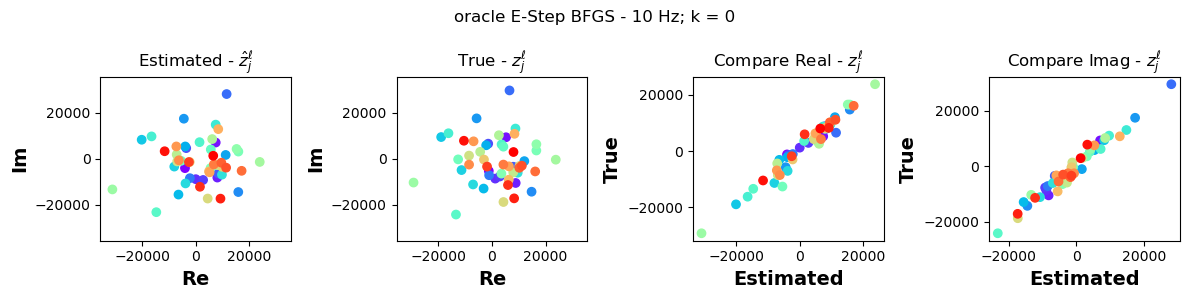

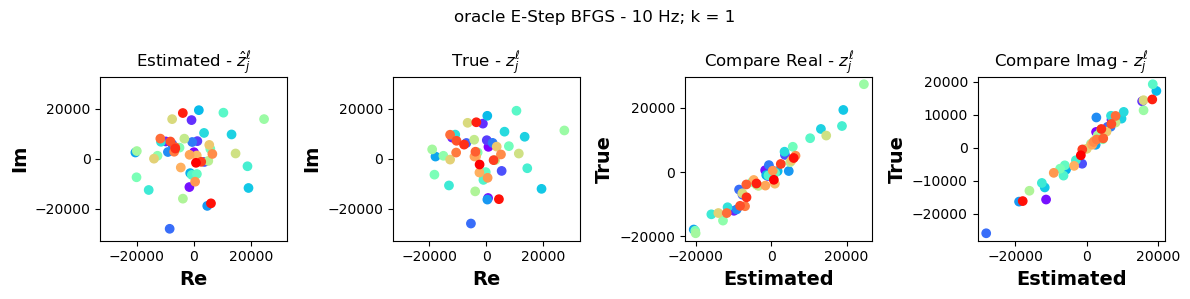

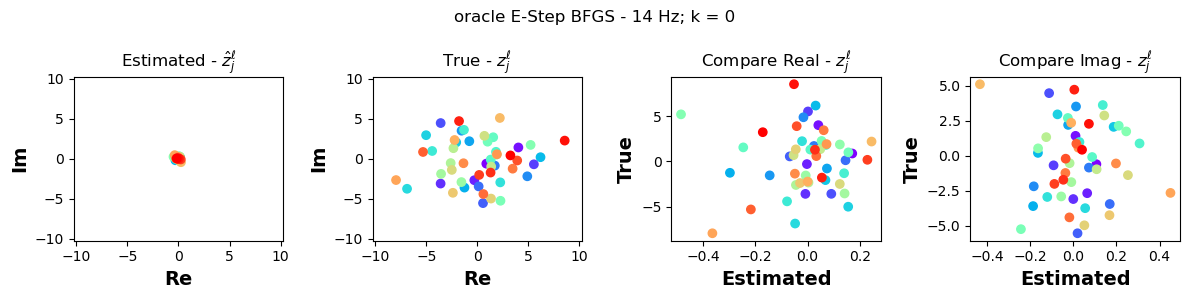

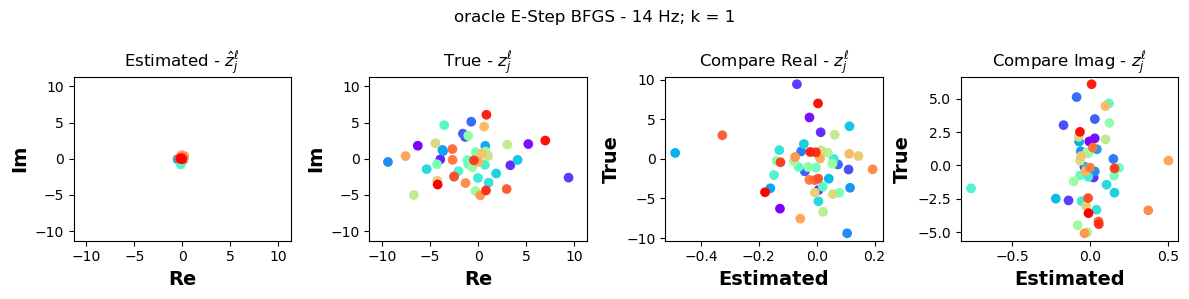

In [133]:
init_type = 'oracle'
optim_type = 'BFGS'
mus = run_E_step(init_type, optim_type, estep_params)
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,False)

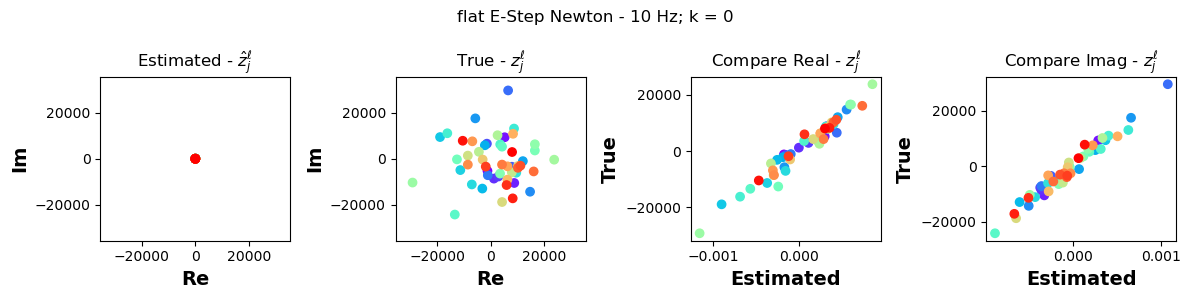

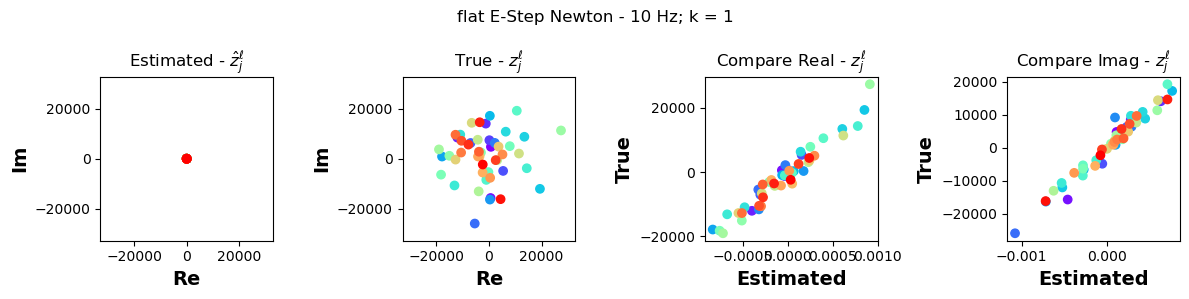

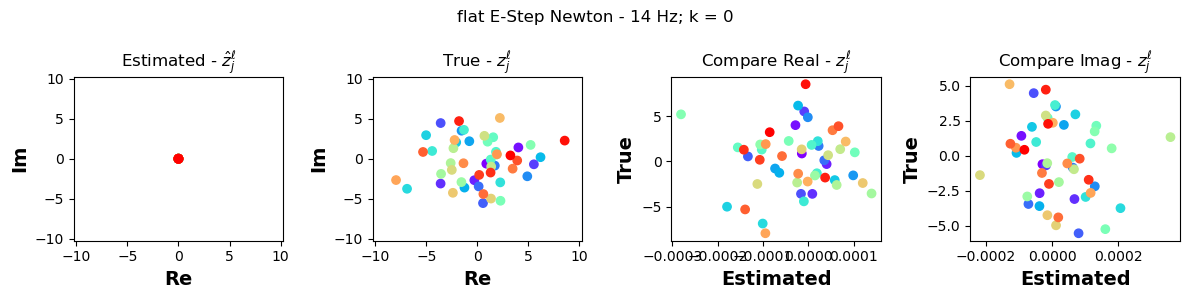

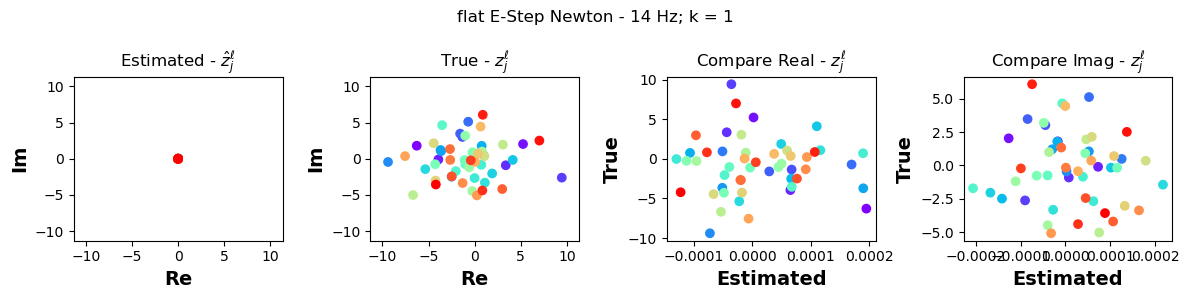

In [134]:
init_type = 'flat'
optim_type = 'Newton'
mus = run_E_step(init_type, optim_type, estep_params)
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,False)

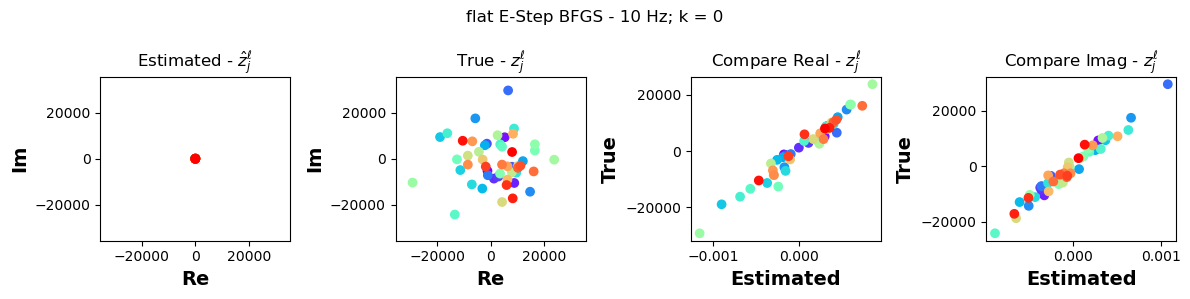

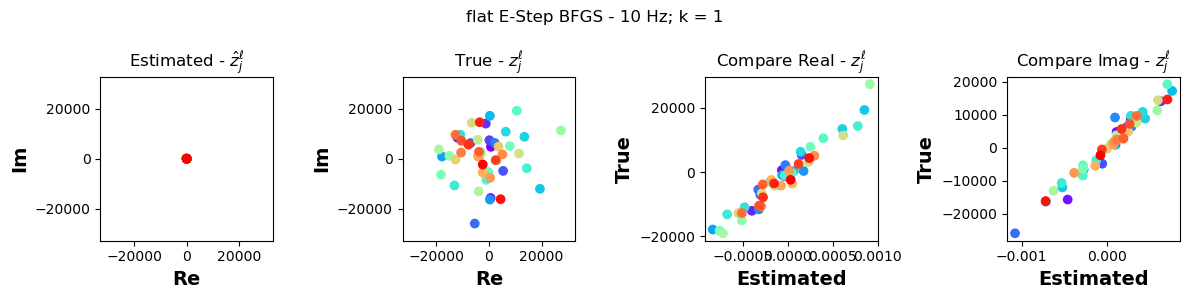

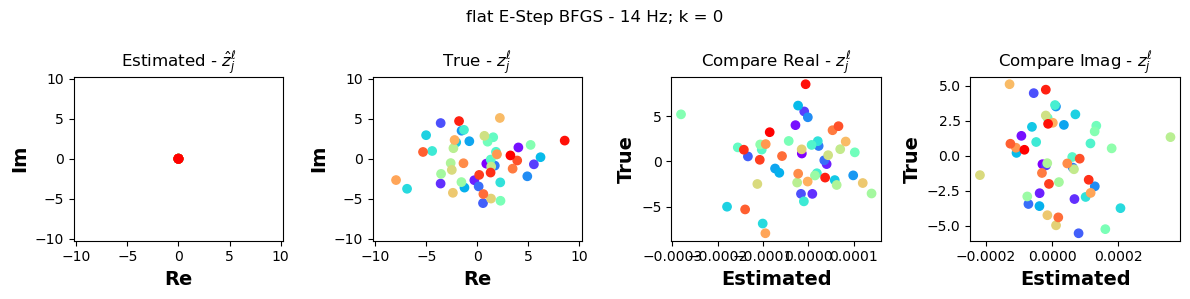

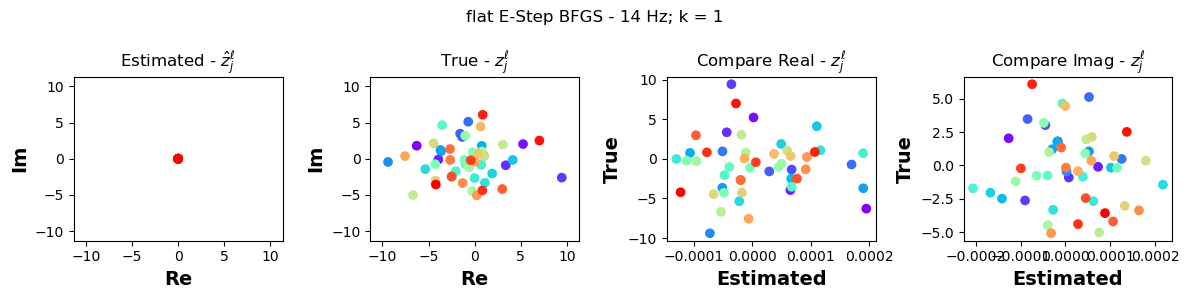

In [135]:
init_type = 'flat'
optim_type = 'BFGS'
mus = run_E_step(init_type, optim_type, estep_params)
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,False)

In [ ]:
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,True)

In [ ]:
init_type = 'oracle'
optim_type = 'Newton'
mus = run_E_step(init_type, optim_type, estep_params)
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,False)

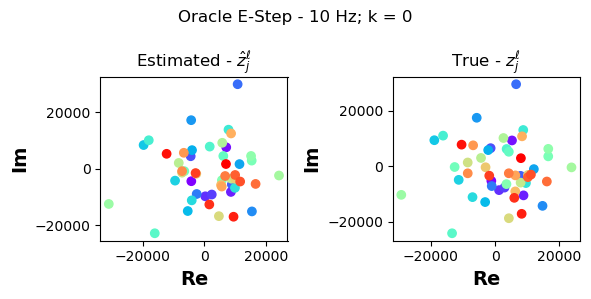

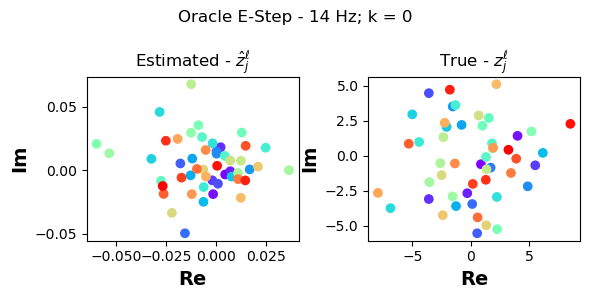

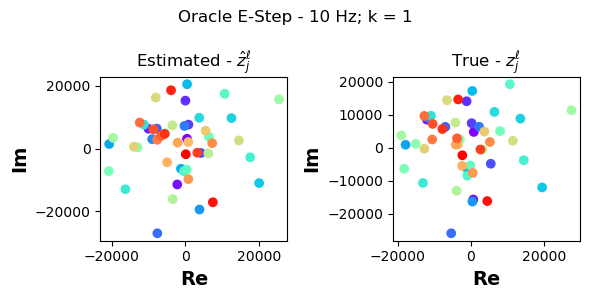

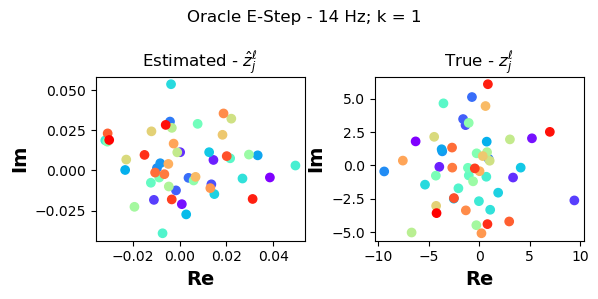

In [84]:
for j in [9, 13]:
    for k in range(K):
        plot_optim_result(mus,zs,init_type,optim_type,j,k,True)

In [76]:
def get_freq_vecs_real(vec, K, num_J_vars):
    """
    Un-vectorize over frequencies.
    """
    j_vecs = []
    for jv in range(0, num_J_vars, 2):
        base_filt = np.zeros(num_J_vars)
        base_filt[jv : jv + 2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        j_vecs.append(vec_j)
    return j_vecs

In [ ]:

free_scale = True

mus_sorted = np.zeros((L, J_max, 2*K))
for l in range(L):
    mus_sorted[l,:,:] = np.stack(get_freq_vecs_real(mus[l,:], K, num_J_vars))
mus_sorted = mus_sorted.swapaxes(1,2)

mus_z = conv_v_to_z(mus_sorted[:,:,], axis=1, dc=False)
zs = conv_v_to_z(vs[:,:,:num_J_vars], axis=2, dc=False)

color = plt.cm.rainbow(np.linspace(0, 1, L))
k = 0
j = 9
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(mus_z[:,k,j].real, mus_z[:,k,j].imag, c=color)
ax[0].set_title(f'Estimated -' + r' $\hat{z}_j^{\ell}$')
ax[1].scatter(zs[:,k,j].real, zs[:,k,j].imag, c=color)
ax[1].set_title(f'True -' + r' $z_j^{\ell}$' )

fig.suptitle(f'Oracle E-Step - {j+1} Hz; k = {k}')
# ax[1].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
# ax[1].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
# ax[1].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
for i in range(2):
    ax[i].set_xlabel('Re', fontweight='bold', fontsize=14)
    ax[i].set_ylabel('Im', fontweight='bold', fontsize=14)
if free_scale is False:
    ax[0].set_xlim([-lim,lim])
    ax[0].set_ylim([-lim,lim])
plt.tight_layout()
plt.show()

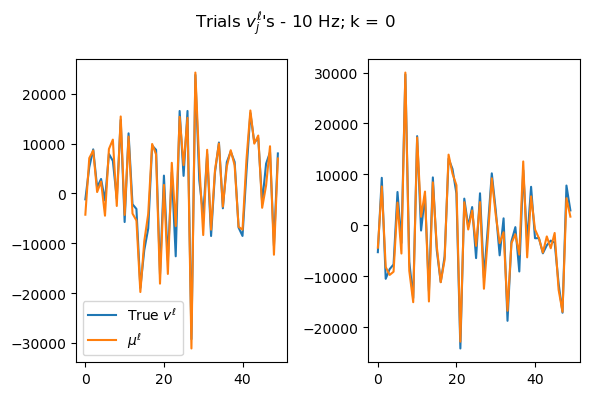

In [50]:
free_scale = True
k = 0

mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)

vs_k = vs[:,k,:num_J_vars]
zs_zk = conv_v_to_z(vs_k, axis=1, dc=False)

color = plt.cm.rainbow(np.linspace(0, 1, L))


j = 9
m1 = j*2
m2 = m1+1
fig, ax = plt.subplots(1,2,figsize=(6,4))
# fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(vs_k[:,m1], label='True $v^{\\ell}$')
ax[0].plot(mus[:,m1], label='$\\mu^{\\ell}$')
ax[0].legend()
ax[1].plot(vs_k[:,m2])
ax[1].plot(mus[:,m2])
fig.suptitle(f'Trials ' + '$v_j^{\\ell}$' + f'\'s - {j+1} Hz; k = {k}')
plt.tight_layout()

# fig, ax = plt.subplots(1,2,figsize=(8,4))
# ax[0].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
# ax[0].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
# ax[0].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

# ax[1].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
# ax[1].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
# ax[1].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}')

# lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
# for i in range(2):
#     ax[i].set_xlabel('Real')
#     ax[i].set_xlabel('Imag')
# if free_scale is False:
#     ax[0].set_xlim([-lim,lim])
#     ax[0].set_ylim([-lim,lim])
# plt.tight_layout()
# plt.show()

-0.01981082153770092

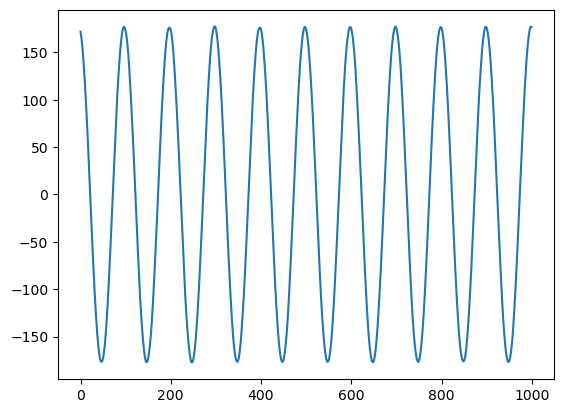

In [68]:
plt.plot(xs[0,0,:])
xs[:,:,:].mean()

In [79]:
np.where(np.abs(vs[0,0,:]) > 25)

(array([18, 19]),)

In [15]:
mags = np.abs(zs[0,0,:])
np.where(mags > 24)


(array([9]),)

(0.0, 30.0)

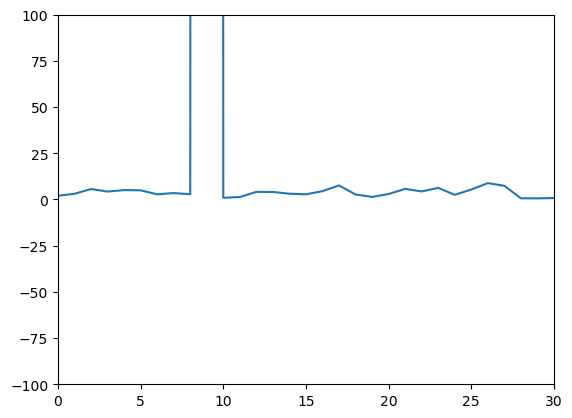

In [16]:
plt.plot(np.abs(zs[0,0,:]))
plt.ylim([-100,100])
plt.xlim([0,30])

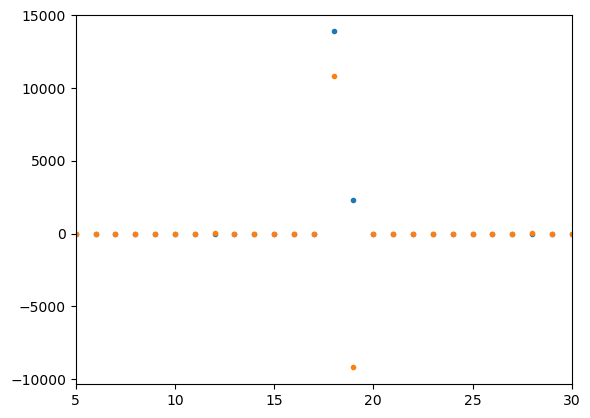

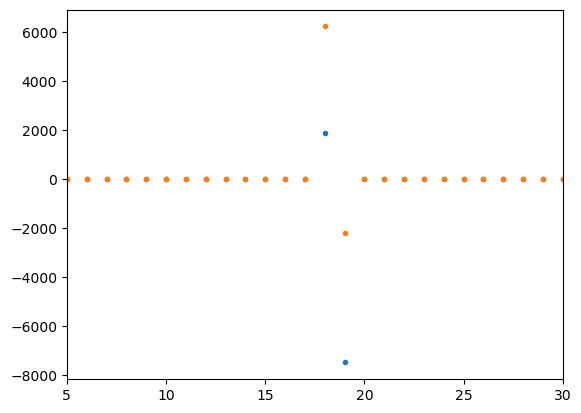

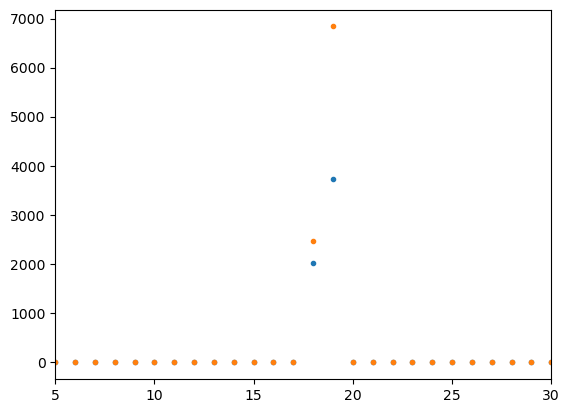

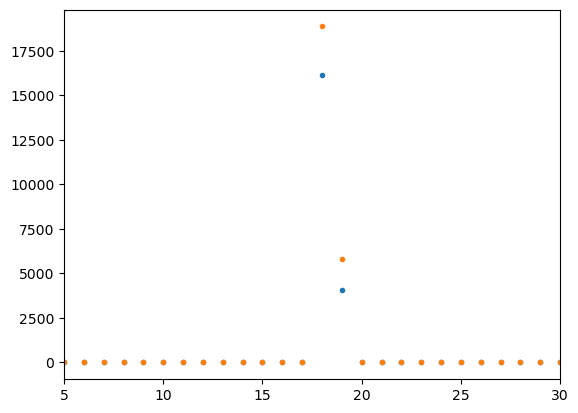

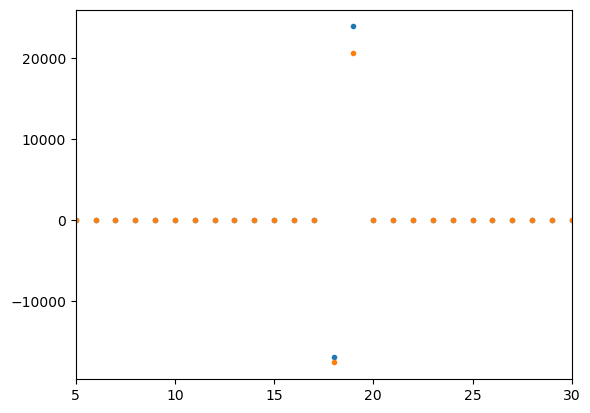

In [20]:
for l in range(5):
    plt.plot(vs[l,0,:], '.')
    plt.plot(vs[l,1,:], '.')
    # plt.ylim([-100,100])
    plt.xlim([5,30])
    plt.show()

In [23]:
num_J_vars

98

In [30]:
vs_k = vs[:,k,:num_J_vars]
mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]

In [38]:
l = 0

In [ ]:
r = 19
k = 0
# for r in range(20):
#     mus = model_load['track'][0][r]['mus']
#     mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
#     # plt.plot(mus_zk.mean(0).real)
#     np.abs(mus_zk.mean(0))**2
#     plt.plot(np.abs(mus_zk.mean(0))**2)
j = 9
K = 2

stitr = 5
enditr = stitr+5

free_scale = False

fig, ax = plt.subplots(2,5,figsize=(18,6))
for i, r in enumerate(range(enditr, stitr, -1)):
    i = 4-i
    for k in range(K):
        mus = model_load['track'][0][r]['mus']
        mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
        mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
        color = plt.cm.rainbow(np.linspace(0, 1, L))

        ax[k,i].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
        ax[k,i].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
        # ak,x[i].set_title(r'$z_{j=5}$', f'; em-iter {r+1}')
        ax[k,i].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}; em-iter {r+1}')
        ax[k,i].set_xlabel('Real')
        ax[k,i].set_xlabel('Imag')
        if i == 4:
            print('ping')
            lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
        if free_scale is False:
            ax[k,i].set_xlim([-lim,lim])
            ax[k,i].set_ylim([-lim,lim])
plt.tight_layout()
plt.show()


# mus.shape
# for l in range(L):
#     mu_l = mus[l,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mu_zl = conv_v_to_z(mu_l, axis=0, dc=False)
#     plt.plot(np.abs(mu_zl))